In [72]:
import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

import matplotlib.pyplot as plt

Initialize Spark Context

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[2]") \
            .appName("matrix factorization") \
            .getOrCreate()

sc = spark.sparkContext

Read in data

In [19]:
ratings = spark.read \
    .options(inferSchema=True, delimiter=',', header=True) \
    .csv('../data/movies/ratings.csv')

In [22]:
ratings = ratings.drop('timestamp')

In [23]:
ratings.take(2)

[Row(userId=1, movieId=31, rating=2.5),
 Row(userId=1, movieId=1029, rating=3.0)]

# Try training basic ALS model
Reference: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html

In [27]:
ratings = ratings.rdd

In [29]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.274386780044638


In [57]:
print(f"RMSE = {np.sqrt(MSE)}")

RMSE = 0.5238194154903367


## See if the predictions make sense

In [58]:
user_ratings = np.array(ratings.map(lambda r: r[2]).collect())

In [60]:
user_ratings[:10]

array([2.5, 3. , 3. , 2. , 4. , 2. , 2. , 2. , 3.5, 2. ])

In [59]:
user_predictions = np.array(predictions.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect())

In [62]:
user_predictions.round(1)[:10]

array([2.3, 2.9, 2.7, 2.2, 3.7, 2.2, 2.4, 2.2, 3.5, 2. ])

In [63]:
user_ratings[:10] - user_predictions.round(1)[:10]

array([ 0.2,  0.1,  0.3, -0.2,  0.3, -0.2, -0.4, -0.2,  0. ,  0. ])

In [70]:
predicted_minus_actual = (user_predictions - user_ratings).round(1)
predicted_minus_actual

array([-0.2, -0.1, -0.3, ..., -0.6,  0.9,  1. ])

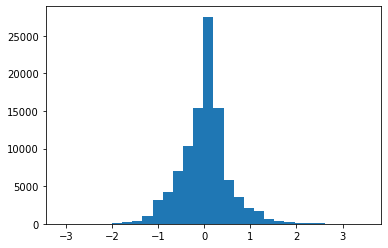

In [76]:
_ = plt.hist(sorted(predicted_minus_actual), bins=30)